## Dane

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download andradaolteanu/gtzan-dataset-music-genre-classification

 99% 1.20G/1.21G [00:30<00:00, 59.1MB/s]
100% 1.21G/1.21G [00:30<00:00, 43.2MB/s]


In [ ]:
! unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
  inflating: Data/features_30_sec.csv  
  inflating: Data/features_3_sec.csv  
  inflating: Data/genres_original/blues/blues.00000.wav  
  inflating: Data/genres_original/blues/blues.00001.wav  
  inflating: Data/genres_original/blues/blues.00002.wav  
  inflating: Data/genres_original/blues/blues.00003.wav  
  inflating: Data/genres_original/blues/blues.00004.wav  
  inflating: Data/genres_original/blues/blues.00005.wav  
  inflating: Data/genres_original/blues/blues.00006.wav  
  inflating: Data/genres_original/blues/blues.00007.wav  
  inflating: Data/genres_original/blues/blues.00008.wav  
  inflating: Data/genres_original/blues/blues.00009.wav  
  inflating: Data/genres_original/blues/blues.00010.wav  
  inflating: Data/genres_original/blues/blues.00011.wav  
  inflating: Data/genres_original/blues/blues.00012.wav  
  inflating: Data/genres_original/blues/blues.00013.wav  
  inflating: Data/genres_original/blues/blues.00014.wa

In [ ]:
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt

--2022-06-12 16:09:30--  https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10152 (9.9K) [text/plain]
Saving to: ‘train_filtered.txt’

train_filtered.txt  100%[===================>]   9.91K  --.-KB/s    in 0s      

2022-06-12 16:09:30 (91.0 MB/s) - ‘train_filtered.txt’ saved [10152/10152]

--2022-06-12 16:09:30--  https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4522 (4.

In [ ]:
with open("Data/train_filtered.txt", "r") as f:
    lines = f.readlines()
with open("Data/train_filtered.txt", "w") as f:
    for line in lines:
        if line.strip("\n") != "jazz/jazz.00054.wav":
            f.write(line)

## Różne biblioteki do augumentacji

In [ ]:
! pip install torchaudio-augmentations
!pip install audiomentations
!pip install pedalboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 6.8 MB/s 
  Created wheel for julius: filename=julius-0.2.6-py3-none-any.whl size=20965 sha256=0611c02657303a58880e8c4adf3bebd559893b057f12d6a823d7f18cbc47cb9d
  Stored in directory: /root/.cache/pip/wheels/ad/6f/00/57039014814f8794b1f32aad93d1d387645d103afdda943caf
Successfully built julius
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 71 kB 9.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.0 MB 15.1 MB/s 


In [ ]:
import os
import random
import torch
import numpy as np
import soundfile as sf
import audiomentations
from torch.utils import data
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)
from audiomentations import (
    Compose,
    AddGaussianNoise,
    TimeStretch,
    Shift,
    PitchShift,
    PolarityInversion,
    Gain,
    TimeMask,
)
from pedalboard import (
    Pedalboard,
    Compressor,
    Chorus,
    Phaser,
    LadderFilter, 
    Reverb,

)
from pedalboard import Gain as P_Gain


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, a_type , num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.a_type = a_type
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        if self.a_type == "torchaudio_augmentations":
          transforms = [
              RandomResizedCrop(n_samples=self.num_samples),
              RandomApply([PolarityInversion()], p=0.8),
              RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
              RandomApply([Gain()], p=0.2),
              RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
              RandomApply([Delay(sample_rate=22050)], p=0.5),
              RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
              RandomApply([Reverb(sample_rate=22050)], p=0.3),
          ]
          self.augmentation = Compose(transforms=transforms)
        elif self.a_type == "audiomentations":
          transforms = [
              AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.15, p=0.3),
              TimeStretch(min_rate=0.75, max_rate=1.25, p=0.4),
              Shift(min_fraction=-0.5, max_fraction=0.5, p=0.4),
              PitchShift(min_semitones=-4, max_semitones=4, p=0.3),
              PolarityInversion(p=0.8),
              Gain(min_gain_in_db=-15.0,max_gain_in_db=10.0,p=0.5),
              TimeMask(min_band_part=0.2, max_band_part=0.5, p=0.5),
          ]
          self.augmentation = Compose(transforms)
        
        elif self.a_type == "pedalboard":
          transforms = Pedalboard([
              Compressor(threshold_db=-40, ratio=10),
              Chorus(),
              Phaser(),
              P_Gain(gain_db=25),
              LadderFilter(mode=LadderFilter.Mode.HPF12, cutoff_hz=900),
              Reverb(room_size=0.30),
          ])
          self.augmentation = transforms


    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav

    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres_original', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            if self.a_type == 'audiomentations' or self.a_type == 'pedalboard':
              wav = self.augmentation(wav, sample_rate=16000)

            else:
              wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()
        return wav, genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train', 
                   a_type = "torchaudio_augmentations",
                   num_samples=22050 * 29, 
                   num_chunks=1, 
                   batch_size=16, 
                   num_workers=0, 
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, 
                                                       split, 
                                                       a_type,
                                                       num_samples, 
                                                       num_chunks, 
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader

In [ ]:
train_loader = get_dataloader(data_path = 'Data/',split='train', a_type = 'audiomentations', is_augmentation=True)
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

valid_loader = get_dataloader(data_path = 'Data/', split='valid')
test_loader = get_dataloader(data_path = 'Data/', split='test')
iter_test_loader = iter(test_loader)
test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav.shape))
print('validation/test data shape: %s' % str(test_wav.shape))
print(train_genre)

training data shape: torch.Size([16, 639450])
validation/test data shape: torch.Size([16, 1, 639450])
tensor([6, 2, 5, 5, 8, 3, 0, 6, 4, 0, 4, 9, 4, 4, 6, 9])


## CNN

In [ ]:
from torch import nn


class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        
    def forward(self, x):
        out = self.maxpool(self.relu(self.bn(self.conv(x))))
        return out

In [ ]:
import torchaudio


class CNN(nn.Module):
    def __init__(self, num_channels=64, 
                       sample_rate=16000, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=8000.0, 
                       num_mels=128, 
                       num_classes=10):
        super(CNN, self).__init__()

        # Spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3, 4))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 5))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels, pooling=(3, 4))

        # dense layers
        self.dense1 = nn.Linear(num_channels, num_channels * 4)
        self.dense_bn = nn.BatchNorm1d(num_channels * 4)
        self.dense2 = nn.Linear(num_channels * 4, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # Spectogram
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)
        out = out.unsqueeze(1)
        out = self.input_bn(out)

        # CNN
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

##Próba dla CRNN


In [ ]:
class CRNN(nn.Module):

    def __init__(self, num_channels=64,
                 sample_rate=16000,
                 n_fft=1024,
                 f_min=0.0,
                 f_max=8000.0,
                 num_mels=128,
                 num_classes=10):
        super(CRNN, self).__init__()


        # Spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = nn.BatchNorm2d(1)


        # CNN
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3, 4))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 5))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 3))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 4))

        # RNN
        self.layer6 = nn.GRU(num_channels * 2, num_channels, 2, batch_first=True)

        # Dense
        self.dense1 = nn.Linear(num_channels, num_channels * 2)
        self.dense_bn = nn.BatchNorm1d(num_channels * 2)
        self.dense2 = nn.Linear(num_channels * 2, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, wav):
        # Spectrogram
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)
        out = out.unsqueeze(1)
        out = self.input_bn(out)

        # CCN

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        # RNN
        out = out.squeeze(2)
        out = out.permute(0, 2, 1)
        out, _ = self.layer6(out)
        out = out[:, -1, :]

        # Dense
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

##Trening


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn = CNN(num_channels=32).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
valid_losses = []
num_epochs = 25

for epoch in range(num_epochs):
    losses = []

    # Train
    cnn.train()
    for (wav, genre_index) in train_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # Forward
        out = cnn(wav)
        loss = loss_function(out, genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    cnn.eval()
    y_true = []
    y_pred = []
    losses = []
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        loss = loss_function(logits, genre_index)
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), 'cnn.ckpt')

Epoch: [1/25], Train loss: 2.3771
Epoch: [1/25], Valid loss: 2.2494, Valid accuracy: 0.1371
Saving the best model at 0 epochs!
Epoch: [2/25], Train loss: 2.2502
Epoch: [2/25], Valid loss: 2.0887, Valid accuracy: 0.3147
Saving the best model at 1 epochs!
Epoch: [3/25], Train loss: 2.1274
Epoch: [3/25], Valid loss: 2.0539, Valid accuracy: 0.2944
Saving the best model at 2 epochs!
Epoch: [4/25], Train loss: 2.1223
Epoch: [4/25], Valid loss: 1.8982, Valid accuracy: 0.3096
Saving the best model at 3 epochs!
Epoch: [5/25], Train loss: 1.9884
Epoch: [5/25], Valid loss: 2.2423, Valid accuracy: 0.1624
Epoch: [6/25], Train loss: 1.9374
Epoch: [6/25], Valid loss: 1.7613, Valid accuracy: 0.2640
Saving the best model at 5 epochs!
Epoch: [7/25], Train loss: 1.9226
Epoch: [7/25], Valid loss: 1.8435, Valid accuracy: 0.4061
Epoch: [8/25], Train loss: 1.8112
Epoch: [8/25], Valid loss: 1.5872, Valid accuracy: 0.4721
Saving the best model at 7 epochs!
Epoch: [9/25], Train loss: 1.7627
Epoch: [9/25], Valid

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
crnn = CRNN(num_channels=32).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(crnn.parameters(), lr=0.001)
valid_losses = []
num_epochs = 25

for epoch in range(num_epochs):
    losses = []

    # Train
    crnn.train()
    for (wav, genre_index) in train_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # Forward
        out = crnn(wav)
        loss = loss_function(out, genre_index)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation
    crnn.eval()
    y_true = []
    y_pred = []
    losses = []
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        loss = loss_function(logits, genre_index)
        losses.append(loss.item())
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    valid_loss = np.mean(losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))

    # Save model
    valid_losses.append(valid_loss.item())
    if np.argmin(valid_losses) == epoch:
        print('Saving the best model at %d epochs!' % epoch)
        torch.save(cnn.state_dict(), 'crnn.ckpt')

Epoch: [1/25], Train loss: 2.3980
Epoch: [1/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Saving the best model at 0 epochs!
Epoch: [2/25], Train loss: 2.2701
Epoch: [2/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [3/25], Train loss: 2.1622
Epoch: [3/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [4/25], Train loss: 2.1487
Epoch: [4/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [5/25], Train loss: 2.0264
Epoch: [5/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [6/25], Train loss: 1.9622
Epoch: [6/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [7/25], Train loss: 1.9198
Epoch: [7/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [8/25], Train loss: 1.9061
Epoch: [8/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [9/25], Train loss: 1.8509
Epoch: [9/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [10/25], Train loss: 1.8255
Epoch: [10/25], Valid loss: 1.1385, Valid accuracy: 0.6599
Epoch: [11/25], Train loss: 1.7447
Epoch: [

## Wyniki

In [ ]:
# Load the best model
S = torch.load('cnn.ckpt')
cnn.load_state_dict(S)
print('loaded!')

# Run evaluation
cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        # reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        logits = cnn(wav.view(-1, t))
        logits = logits.view(b, c, -1).mean(dim=1)
        _, pred = torch.max(logits.data, 1)

        # append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())

loaded!


Accuracy: 0.5793


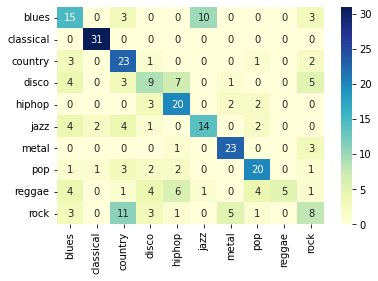

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)